## LeNet Implementation

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip '/content/gdrive/MyDrive/histopathologic-cancer-detection.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
full_train_df = pd.read_csv("/content/train_labels.csv")
full_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
import sklearn

# Number of samples in each class
SAMPLE_SIZE = 5000

# Data paths
train_path = '/content/train/'
test_path = '/content/test/'

# Use 80000 positive and negative examples
df_negatives = full_train_df[full_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = full_train_df[full_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

train_df.shape

(10000, 2)

### Data pre-processing

In [7]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import cv2

In [8]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [9]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    # We the get the following mean and std for the channels of all the images
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

In [10]:
# Set Batch Size
batch_size = 32

# Percentage of training set to use as validation
valid_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#train_subset_data = torch.utils.data.Subset(train_data, range(10001))
#test_subset_data = torch.utils.data.Subset(test_data), range(10001))

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

In [11]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# creating test data
sample_sub = pd.read_csv("/content/sample_submission.csv")
test_data = CreateDataset(df_data=sample_sub, data_dir=test_path, transform=transforms_test)

# prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Modeling

In [12]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

In [18]:
LeNet = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(22*22*16, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 1),
    nn.Sigmoid()
)

In [19]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [20]:
def print_dim(model, input_size):
  X = torch.rand(size=(1, 3, input_size, input_size), dtype=torch.float32)
  for layer in model:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

In [21]:
print_dim(LeNet,96)

Conv2d output shape: 	 torch.Size([1, 6, 96, 96])
ReLU output shape: 	 torch.Size([1, 6, 96, 96])
AvgPool2d output shape: 	 torch.Size([1, 6, 48, 48])
Conv2d output shape: 	 torch.Size([1, 16, 44, 44])
ReLU output shape: 	 torch.Size([1, 16, 44, 44])
AvgPool2d output shape: 	 torch.Size([1, 16, 22, 22])
Flatten output shape: 	 torch.Size([1, 7744])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 1])
Sigmoid output shape: 	 torch.Size([1, 1])


In [22]:
transform_enlarge = transforms.Compose([transforms.Resize(96),
                                    transforms.ToTensor()])

In [23]:
# create a complete CNN
model = LeNet
print(model)

# Move model to GPU if available
if train_on_gpu: model.cuda()         

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=7744, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=1, bias=True)
  (12): Sigmoid()
)


In [24]:
import torch.optim as optim
from sklearn.metrics import roc_auc_score

In [25]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [26]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf

# keeping track of losses as it happen
train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target.float())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target.float())
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #output = output.topk()
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))        
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))
    
    ##################
    # Early Stopping #
    ##################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 | Training Loss: 0.559365 | Validation Loss: 0.513633 | Validation AUC: 0.8212
Validation loss decreased (inf --> 0.513633).  Saving model ...
Epoch: 2 | Training Loss: 0.512376 | Validation Loss: 0.498919 | Validation AUC: 0.8372
Validation loss decreased (0.513633 --> 0.498919).  Saving model ...
Epoch: 3 | Training Loss: 0.498087 | Validation Loss: 0.465254 | Validation AUC: 0.8375
Validation loss decreased (0.498919 --> 0.465254).  Saving model ...
Epoch: 4 | Training Loss: 0.488924 | Validation Loss: 0.463240 | Validation AUC: 0.8422
Validation loss decreased (0.465254 --> 0.463240).  Saving model ...
Epoch: 5 | Training Loss: 0.480001 | Validation Loss: 0.479365 | Validation AUC: 0.8488
Epoch: 6 | Training Loss: 0.470020 | Validation Loss: 0.456799 | Validation AUC: 0.8524
Validation loss decreased (0.463240 --> 0.456799).  Saving model ...
Epoch: 7 | Training Loss: 0.466686 | Validation Loss: 0.441781 | Validation AUC: 0.8556
Validation loss decreased (0.456799 --> 0.44

In [27]:
# Load Best parameters learned from training into our model to make predictions later
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [28]:
model.eval()

preds = []
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        preds.append(i)

# Create Submission file        
sample_sub['label'] = preds

In [29]:
for i in range(len(sample_sub)):
    sample_sub.label[i] = np.float(sample_sub.label[i]) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [30]:
sample_sub.to_csv('submission.csv', index=False)
sample_sub.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.015949
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.732604
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.083258
3,2c35657e312966e9294eac6841726ff3a748febf,0.372872
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.265467


### Visualizing Predictions

In [31]:
def imshow(img):
    '''Helper function to un-normalize and display an image'''
    # unnormalize
    img = img / 2 + 0.5
    # convert from Tensor image and display
    plt.imshow(np.transpose(img, (1, 2, 0)))

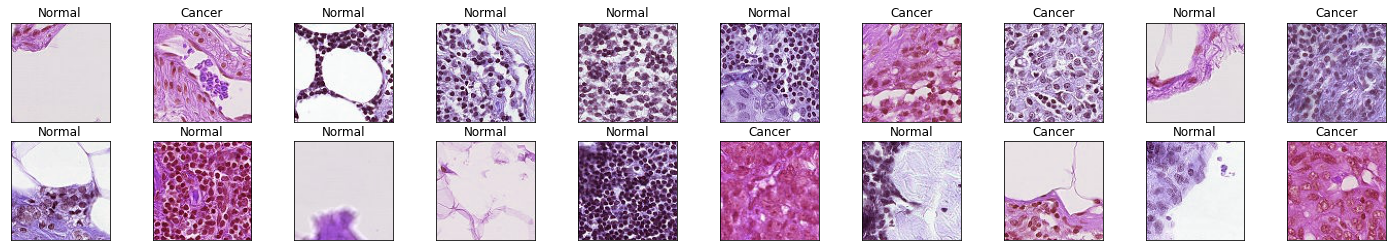

In [32]:
# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    prob = "Cancer" if(sample_sub.label[idx] >= 0.5) else "Normal" 
    ax.set_title('{}'.format(prob))